In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 13.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import skfuzzy as fuzz
from skfuzzy import control as ctrl



In [ ]:
URL_CSV = 'https://docs.google.com/spreadsheets/d/174b-2TrnKXzt7gLELaiw3CkIdpQpQ0UV/gviz/tq?tqx=out:csv&gid=0'
df = pd.read_csv(URL_CSV, sep=',', decimal=',')

In [ ]:
df = df.rename(columns={'Rotacao (%)': 'Rotacao', 'Pressao (bar)': 'Pressao', 'Vazao t/h': 'Vazao'})
df['Data/Hora'] = pd.to_datetime(df['Data/Hora Timestamp'])
df = df.set_index('Data/Hora').sort_index()

/tmp/ipython-input-3529107019.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Data/Hora'] = pd.to_datetime(df['Data/Hora Timestamp'])


In [ ]:
# --- controlador fuzzy ---
p_range = np.arange(0, 140.1, 0.1)
v_range = np.arange(0, 251.1, 0.1)
r_range = np.arange(0, 101.1, 1)

pressao = ctrl.Antecedent(p_range, 'Pressao')
vazao   = ctrl.Antecedent(v_range, 'Vazao')
rotacao = ctrl.Consequent(r_range, 'Rotacao')

# --- funções de pertinência ---
pressao['Baixa'] = fuzz.trapmf(p_range, [0, 0, 23.3, 46.7])
pressao['Media'] = fuzz.trimf(p_range, [23.3, 65, 90.0])   # set‑point 65 bar
pressao['Alta']  = fuzz.trapmf(p_range, [70, 116.7, 140, 140])

vazao['Baixa'] = fuzz.trapmf(v_range, [0, 0, 50, 100])
vazao['Media'] = fuzz.trimf(v_range, [50, 125, 200])
vazao['Alta']  = fuzz.trapmf(v_range, [150, 200, 250, 250])

rotacao['Lenta'] = fuzz.trapmf(r_range, [0, 0, 20, 40])
rotacao['Media'] = fuzz.trimf(r_range, [20, 50, 80])
rotacao['Rapida']= fuzz.trapmf(r_range, [60, 80, 100, 100])

# --- regras fuzzy ---
regra1 = ctrl.Rule(pressao['Baixa'] & vazao['Baixa'], rotacao['Rapida'])
regra2 = ctrl.Rule(pressao['Baixa'] & vazao['Media'], rotacao['Rapida'])
regra3 = ctrl.Rule(pressao['Baixa'] & vazao['Alta'],  rotacao['Rapida'])
regra4 = ctrl.Rule(pressao['Media'] & vazao['Baixa'], rotacao['Media'])
regra5 = ctrl.Rule(pressao['Media'] & vazao['Media'], rotacao['Media'])
regra6 = ctrl.Rule(pressao['Media'] & vazao['Alta'],  rotacao['Lenta'])
regra7 = ctrl.Rule(pressao['Alta']  & vazao['Baixa'], rotacao['Lenta'])
regra8 = ctrl.Rule(pressao['Alta']  & vazao['Media'], rotacao['Lenta'])
regra9 = ctrl.Rule(pressao['Alta']  & vazao['Alta'],  rotacao['Lenta'])

ctrl_sys = ctrl.ControlSystem([regra1,regra2,regra3,regra4,regra5,regra6,regra7,regra8,regra9])
sim     = ctrl.ControlSystemSimulation(ctrl_sys)

def passo_fuzzy(p, v):
    sim.input['Pressao'] = p
    sim.input['Vazao']   = v
    sim.compute()
    return sim.output.get('Rotacao', np.nan)

# aplicando o controle a cada linha
df['rotacao_fuzzy'] = df.apply(lambda r: passo_fuzzy(r['Pressao'], r['Vazao']), axis=1)

# salvando o resultado
URL_DRIVE = 'https://drive.google.com/drive/folders/1SMf1JwMMfHOyM8ejo3AGFLAqPQqcXzNG?usp=drive_link/dados_caldeira_com_fuzzy.xlsx'
df.to_csv(URL_DRIVE, index=True)

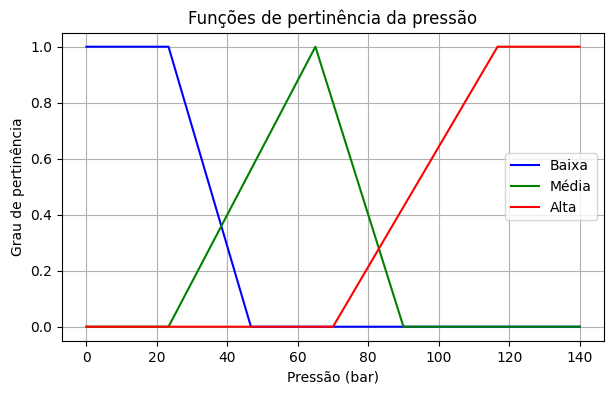

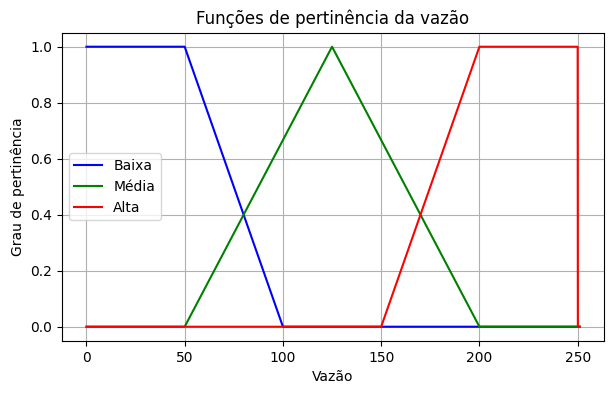

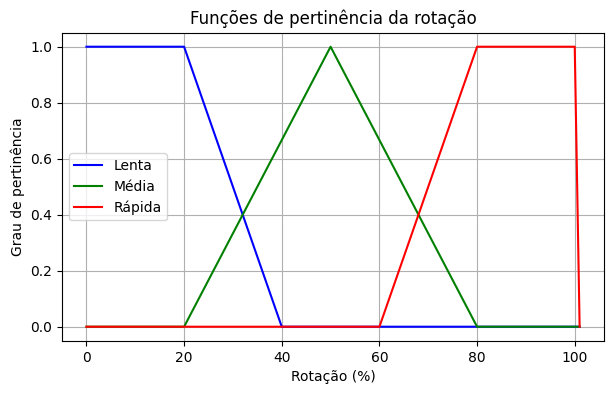

In [ ]:
# --- gráfico funções de pertinência ---

# --- pressão ---
plt.figure(figsize=(7, 4))
plt.plot(p_range, pressao['Baixa'].mf, 'b', label='Baixa')
plt.plot(p_range, pressao['Media'].mf, 'g', label='Média')
plt.plot(p_range, pressao['Alta'].mf,  'r', label='Alta')

plt.title('Funções de pertinência da pressão')
plt.xlabel('Pressão (bar)')
plt.ylabel('Grau de pertinência')
plt.legend()
plt.grid(True)
plt.show()


# --- vazão ---
plt.figure(figsize=(7, 4))
plt.plot(v_range, vazao['Baixa'].mf, 'b', label='Baixa')
plt.plot(v_range, vazao['Media'].mf, 'g', label='Média')
plt.plot(v_range, vazao['Alta'].mf,  'r', label='Alta')

plt.title('Funções de pertinência da vazão')
plt.xlabel('Vazão')
plt.ylabel('Grau de pertinência')
plt.legend()
plt.grid(True)
plt.show()

# --- rotação ---
plt.figure(figsize=(7, 4))
plt.plot(r_range, rotacao['Lenta'].mf, 'b', label='Lenta')
plt.plot(r_range, rotacao['Media'].mf, 'g', label='Média')
plt.plot(r_range, rotacao['Rapida'].mf, 'r', label='Rápida')

plt.title('Funções de pertinência da rotação')
plt.xlabel('Rotação (%)')
plt.ylabel('Grau de pertinência')
plt.legend()
plt.grid(True)
plt.show()

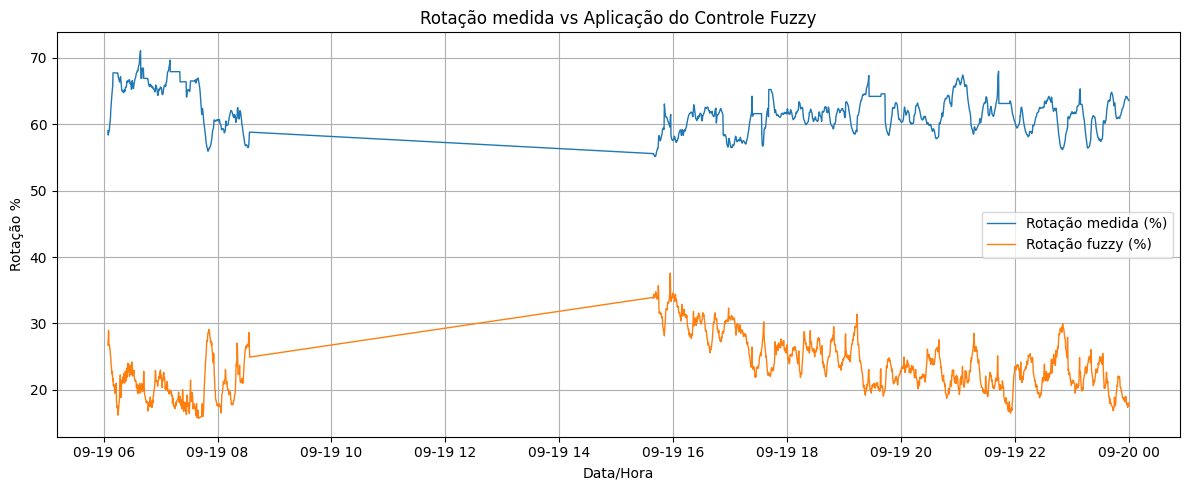

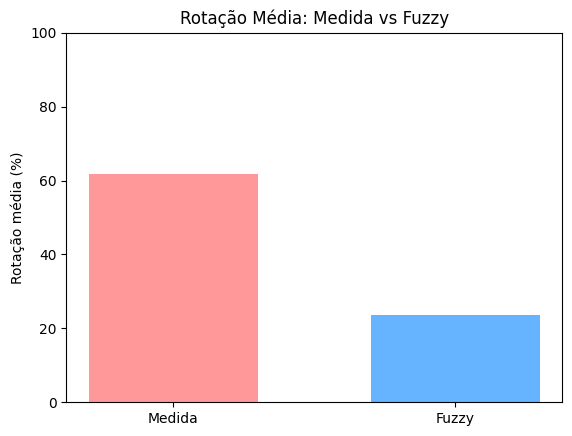

In [ ]:
# --- gráficos de comparação ---

#gráfico de linha
plt.figure(figsize=(12,5))
plt.plot(df.index, df['Rotacao'], label='Rotação medida (%)', linewidth=1)
plt.plot(df.index, df['rotacao_fuzzy'], label='Rotação fuzzy (%)', linewidth=1)
plt.title('Rotação medida vs Aplicação do Controle Fuzzy')
plt.xlabel('Data/Hora')
plt.ylabel('Rotação %')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#gráfico de rosca
medida = df['Rotacao'].mean()
fuzzy  = df['rotacao_fuzzy'].mean()

labels = ['Medida', 'Fuzzy']
valores = [medida, fuzzy]
cores = ['#ff9999', '#66b3ff']

x = np.arange(len(labels))
plt.bar(x, valores, color=cores, width=0.6)
plt.xticks(x, labels)
plt.ylabel('Rotação média (%)')
plt.title('Rotação Média: Medida vs Fuzzy')
plt.ylim(0, 100)
plt.show()